In [1]:
import sqlalchemy as sq
import pymysql

import pandas as pd
import numpy as np

import os
import csv

import datetime as dt

from bs4 import BeautifulSoup

sq.__version__

'1.0.13'

In [2]:
def convert_unixtime(stamp):
    return dt.datetime.fromtimestamp(
        int(stamp)
    ).strftime('%Y-%m-%d')

## Set up Dept List/Dict

In [4]:
dept_dict = {}

data_path = r'/home/toferc/Documents/Data/'
output_path = r'/home/toferc/Documents/Data/'

In [5]:
with open(os.path.join(data_path, 'csv_keys.csv'), "r") as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    
    for row in reader:
        email, acronym = row
        dept_dict[email] = acronym

dept_dict['cadets.gc.ca'] = 'CADETS'
dept_dict['canada.gc.ca'] = 'CANADA'
dept_dict['canada.ca'] = 'CANADA'
dept_dict['tribunal.gc.ca'] = 'TRIBUNAL'
dept_dict['cannor.gc.ca'] = 'CED/DEC'
dept_dict['ci-oic.gc.ca'] = 'CI/OIC'
dept_dict['ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['god.ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['clo-ocol.gc.ca'] = 'OCOL/CLO'
dept_dict['csps.gc.ca'] = 'CSPS/EFPC'
dept_dict['interenational.gc.ca'] = 'DFAITD/MAECD'
dept_dict['cnb-ncw.gc.ca'] = 'CNB/NCW'
dept_dict['ncw-cnb.gc.ca'] = 'CNB/NCW'
dept_dict['nfb.gc.ca'] = 'NFB/ONF'
dept_dict['nrccan-rncan.gc.ca'] = 'NRCAN/RNCAN'
dept_dict['nserc-crsng.gc.ca'] = 'NSERC/CRSNG'
dept_dict['pbc-clcc.gc.ca'] = 'PBC/CLCC'
dept_dict['pco.bcp.gc.ca'] = 'PCO/BCP'
dept_dict['pipsc.ca'] = 'PIPSC/IPFPC'
dept_dict['ps.sp.gc.ca'] = 'PS/SP'
dept_dict['servicecanada.gc.ca.gc.ca'] = 'HRSDC/RHDSC'
dept_dict['fintrac-canafe.gc.ca'] = 'FINTRAC'
dept_dict['gmail.com'] = 'GMAIL'
dept_dict['tribunbal.gc.ca'] = 'TRIBUNAL'

FileNotFoundError: [Errno 2] No such file or directory: '/home/toferc/Documents/Data/csv_keys.csv'

In [6]:
def find_dept(email):
    ampersand = email.find('@')
    tail = email[ampersand + 1:]
    try:
        return dept_dict[tail]
    except KeyError:
        return "OTHER"

In [7]:
dept_list = []

for k, v in dept_dict.items():
    dept_list.append(v)

dept_list = set(dept_list)

In [ ]:
# Load CIOC members and FTE counts

cioc_depts = pd.read_csv(os.path.join(data_path, 'CIOC_depts_jan_2016.csv'),
                        thousands=',')

In [ ]:
cioc_depts.describe()

## Connect to DB

In [16]:
import getpass

password = getpass.getpass('Enter Password: ')

Enter Password: ········


In [17]:
# MariahDB = 165
# MYSQL = 117

db_connection = "mysql+pymysql://elgg:{}@192.168.1.99:3306/elgg".format(
    password)

In [18]:
engine = sq.create_engine(db_connection,encoding='latin1', echo=False)

In [19]:
conn = engine.connect()

In [20]:
engine.connect()

In [21]:
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import and_, or_
Session = sessionmaker(bind=engine)

In [22]:
Session.configure(bind=engine)
session = Session()

In [23]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [24]:
# Set up mappings

Users = Base.classes.elggusers_entity
Groups = Base.classes.elgggroups_entity
Relationships = Base.classes.elggentity_relationships
Entities = Base.classes.elggentities
Objects = Base.classes.elggobjects_entity
MetaData = Base.classes.elggmetadata
MetaStrings = Base.classes.elggmetastrings
Annotations = Base.classes.elggannotations


### Guide to Elgg Entities

Blogs = Entities(subtype=5)
Group_Members = Users(relationship=member)
Discussions = Entities(subtype=7)
Pages = Entities(subtype=10)
Wire = Entities(subtype=17)

Content = Entities(subtype) -> entity_guid
    Elggmetadata(entity_guid) -> name_id, value_id
    Elggmetastrings(name_id OR value_id)
    
#Comments
Blog is container entity - GUID = blog guid

Blog guid = 10
search container for blog guid, return container guid
elggmetadata(container_guid)
Elggmetastrings(name_id OR value_id)

#Skills
user_GUID -> elggmetadata(container_guid) - name_id = 60

In [25]:
# Set up subtype objects of interest

subtypes = {'blogs': 5,
            'discussions': 7,
            'pages': 10,
            'wires': 17,
            'files': 1,
            'images': 19,
            'bookmarks': 8,
            'ideas': 42
           }

subtype_list = "5 7 10 17 1 19 8 42".split()

### Users

In [ ]:
users = {}

for e, u in session.query(Entities, Users).filter(
    Entities.guid == Users.guid):
    users[e.guid] = (e.guid, u.name,
                 find_dept(u.email), 
                 convert_unixtime(e.time_created),
                  convert_unixtime(u.last_login),
                )

In [ ]:
users[4]

## Groups

In [ ]:
# Pull groups from DB

groups = []

for group, entity in session.query(
    Groups, Entities).filter(
        Entities.guid == Groups.guid):
    groups.append((group.guid, group.name, 
                   group.description,
                   users[entity.owner_guid][2], 
                   convert_unixtime(entity.time_created)))

In [ ]:
# Pull tags from DB

group_tags = []

for group, entity, data, strings in session.query(
    Groups, Entities, MetaData, MetaStrings).filter(
        Groups.guid == Entities.guid,
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    group_tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [29]:
def camel_case(text):
    # convert text to camel case (lower, no spaces)
    tokens = text.lower().split()
    output = "_".join(tokens)
    return output

In [30]:
def replace_string_id(tag_list):
    return [camel_case(strings.get(t).lower()) for t in tag_list]

In [ ]:
from collections import defaultdict

In [ ]:
# Scripts for sorting tags and linking them to guids

tag_dict = defaultdict(list)

for data in group_tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string == 'interests':
        tag_dict.setdefault(guid, []).append(value_id)

strings = {}
        
for data in group_tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string

group_tags = defaultdict(list)

for k, v in tag_dict.items():
    group_tags[k] = replace_string_id(v)


In [ ]:
group_tags

In [ ]:
# Connect groups and tags

group_info = []

for group in groups:
    guid, name, description, department, created = group
    name = BeautifulSoup(name, "lxml")
    description = BeautifulSoup(description, "lxml")
    tags = group_tags.get(guid, "None")
    group_info.append([guid, name.text, description.text, department, created, tags])

In [ ]:
group_df = pd.DataFrame(group_info,
                       columns = "guid name description department created tags".split())

group_df.head()

In [ ]:
group_df.to_csv(os.path.join(output_path, "groups.csv"))

### Pull Group Discussions

In [ ]:
# Test for pulling out blog info
# Cut out: entity.guid, entity.subtype, user.name, objects.title, 

discussions = []

for entity, objects in session.query(
    Entities, Objects).filter(
        Entities.subtype == 7,
        Objects.guid == Entities.guid):
    discussions.append((objects.guid, objects.title, objects.description,
                 entity.container_guid, users[entity.owner_guid][2],
                        entity.owner_guid, convert_unixtime(entity.time_created)))

In [ ]:
discussion_tags = []

for entity, data, strings in session.query(
    Entities, MetaData, MetaStrings).filter(
        Entities.subtype == 7,
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    discussion_tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [ ]:
# Scripts for sorting tags and linking them to guids

tag_dict = defaultdict(list)

for data in discussion_tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string == 'tags':
        tag_dict.setdefault(guid, []).append(value_id)
        
strings = {}
        
for data in discussion_tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string

d_tags = defaultdict(list)

for k, v in tag_dict.items():
    d_tags[k] = replace_string_id(v)


In [ ]:
d_tags

In [ ]:
# Connect discussions and tags

discussion_info = []

for discussion in discussions:
    guid, title, description, container_guid, department, owner, created = discussion
    title = BeautifulSoup(title, "lxml")
    description = BeautifulSoup(description, "lxml")
    tags = d_tags.get(guid, "None")
    discussion_info.append([guid, title.text, description.text, container_guid, 
                       department, owner, created, tags])

In [ ]:
discussion_df = pd.DataFrame(discussion_info, columns="guid title description container department owner created tags".split())

In [ ]:
discussion_df.head(50)

### Group Memberships

In [ ]:
members = []

for r in session.query(Relationships).filter(
    Relationships.relationship == 'member'):
        members.append((
            r.guid_one, r.guid_two, convert_unixtime(r.time_created)))

In [ ]:
creator_link = []

for d in discussion_info:
    discussion = d[0]
    creator = d[5]
    created = d[6]
    creator_link.append([creator, discussion, created])

### Graph

In [ ]:
# Connect discussions with groups and graph

import networkx as nx

In [ ]:
G = nx.DiGraph()

In [ ]:
# Create group nodes

for group in group_info:
    guid, name, description, owner_guid, created, tags = group
    G.add_node(guid, type='group', name=name, description=description, 
               created=created)

In [ ]:
# Create discussion nodes

for discussion in discussion_info:
    guid, title, description, container_guid, department, owner, created, tags = discussion
    G.add_node(guid, type='discussion', title=title, description=description, created=created)

In [ ]:
# Create user nodes

for user in users:
    guid, name, department, created, login = users[user]
    G.add_node(guid, type='user',
               name=name,
               department=department, 
               created=created)

In [ ]:
# Create discussion edges

for discussion in discussion_info:
    guid, title, description, container_guid, departnment, owner, created, tags = discussion
    G.add_edge(guid, container_guid, created=created)

In [ ]:
# Create membership edges

for edge in members:
    user, group, connected = edge
    
    G.add_edge(user, group, date=connected)

In [ ]:
# Create author edges

for edge in creator_link:
    user, discussion, created = edge
    
    G.add_edge(user, discussion, date=created)

In [ ]:
nx.write_graphml(G, os.path.join(output_path, 'groups_discussions_graph.graphml'))

### Tags and frequency distribution

In [26]:
# Now with all the tags

all_tags = []

for entity, data, strings in session.query(
    Entities, MetaData, MetaStrings).filter(
        Entities.subtype.in_(subtype_list),
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    all_tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [31]:
# Scripts for sorting tags and linking them to guids

from collections import defaultdict

tag_dict = defaultdict(list)

for data in all_tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string in 'tags interests':
        tag_dict.setdefault(guid, []).append(value_id)
        
strings = {}
        
for data in all_tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string

all_tags_final = defaultdict(list)

for k, v in tag_dict.items():
    all_tags_final[k] = replace_string_id(v)


In [32]:
# Set up the output map

tag_map = defaultdict(int)

In [33]:
def link_tags(tags):
    tag_links = []
    list1, list2 = tags, tags
    for t1 in list1:
        for t2 in list2:
            if t1 != t2 and [t2, t1] not in tag_links:
                tag_links.append([t1.strip('#'), t2.strip('#')])
    
    for link in tag_links:
        item1, item2 = link
        tag_map['{} {}'.format(item1, item2)] = tag_map.get(
            '{} {}'.format(item1, item2), 0) + 1

In [34]:
for item in group_tags:
    link_tags(group_tags[item])

NameError: name 'group_tags' is not defined

In [35]:
for item in all_tags_final:
    link_tags(all_tags_final[item])

In [36]:
all_tags_final

defaultdict(list,
            {643: ['virtual_worlds', 'second_life', 'cbsa'],
             926: [''],
             1753: [''],
             1838: ['social_networking', 'blog', 'web_2.0', 'wiki'],
             2568: [''],
             2569: [''],
             2571: [''],
             2692: ['members'],
             2932: ['flash', 'actionscript_3.0', 'as3'],
             3303: ['business', 'analysis', 'centre_of_excellence'],
             3304: ['project_management', 'prince2', 'pmbok'],
             3305: ['business',
              'analysis',
              'modeling',
              'notation',
              'diagrams',
              'swimlanes',
              'standard'],
             3438: [''],
             3439: [''],
             3813: ['flash', 'as3'],
             4554: ['rss'],
             4650: ['dds'],
             4720: ['flash', 'actionscript', 'as3'],
             4939: ['calendar'],
             4950: [''],
             5584: ['oil_sands',
              'fort_mcmurray',

In [37]:
tag_map

defaultdict(int,
            {'virtual_worlds second_life': 5,
             'virtual_worlds cbsa': 2,
             'second_life cbsa': 2,
             'social_networking blog': 2,
             'social_networking web_2.0': 8,
             'social_networking wiki': 2,
             'blog web_2.0': 4,
             'blog wiki': 3,
             'web_2.0 wiki': 4,
             'flash actionscript_3.0': 2,
             'flash as3': 5,
             'actionscript_3.0 as3': 1,
             'business analysis': 2,
             'business centre_of_excellence': 1,
             'analysis centre_of_excellence': 1,
             'project_management prince2': 9,
             'project_management pmbok': 6,
             'prince2 pmbok': 5,
             'business modeling': 1,
             'business notation': 1,
             'business diagrams': 1,
             'business swimlanes': 1,
             'business standard': 1,
             'analysis modeling': 2,
             'analysis notation': 1,
           

In [39]:
import networkx as nx

N = nx.Graph()

In [40]:
for k, v in tag_map.items():
    try:
        element_one, element_two = k.split(" ")
        N.add_edge(element_one, element_two, weight=v)
    except ValueError:
        raise

In [41]:
nx.write_gexf(N, os.path.join(output_path, 'all_tags_graph_2017_03_24.gexf'))

### Stopped playing with the full tag cloud here.

In [54]:
# Count the frequency of each tag from our text

tag_frequency = defaultdict(int)

for item in all_tags_final:
    for tag in all_tags_final[item]:
        if tag == "0" or tag == "":
            pass
        else:
            tag_frequency[tag] += 1

In [55]:
tag_freq = pd.DataFrame.from_dict(tag_frequency, orient='index')

In [56]:
tag_freq.columns = ['frequency']
tag_freq.head()

,frequency
virtual_worlds,5
second_life,7
cbsa,39
social_networking,30
blog,55


In [57]:
tag_freq.sort_values(by='frequency', inplace=True, ascending=False)

In [58]:
tag_freq.head()

,frequency
gcconnex,941
leadership,760
gc2020,746
innovation,657
social_media,648


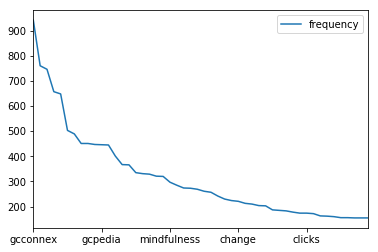

In [59]:
%matplotlib inline

tag_freq.head(50).plot()

In [60]:
tag_freq.to_csv(os.path.join(output_path, 'group_tags_2017_03_24.csv'))

In [61]:
from collections import OrderedDict

In [62]:
# Create a sorted dictionary based on the frequency

sorted_tag_freq = OrderedDict(sorted(tag_frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [63]:
sorted_tag_freq

OrderedDict([('gcconnex', 941),
             ('leadership', 760),
             ('gc2020', 746),
             ('innovation', 657),
             ('social_media', 648),
             ('gcwcc', 503),
             ('blueprint_2020', 489),
             ('learning', 451),
             ('wellness', 451),
             ('collaboration', 447),
             ('gcpedia', 446),
             ('engagement', 445),
             ('clicks_and_tips', 401),
             ('management', 367),
             ('cic', 366),
             ('mental_health', 335),
             ('project_management', 331),
             ('bp2020', 329),
             ('bc_region', 321),
             ('lean', 320),
             ('mindfulness', 297),
             ('web_2.0', 285),
             ('aandc', 274),
             ('training', 273),
             ('communications', 269),
             ('change_management', 261),
             ('cfia', 257),
             ('objectif_2020', 242),
             ('open_source', 230),
             ('twitter', 

In [ ]:
len(group_info)

### Latent Dirichlet Allocation (LDA)

In [ ]:
import logging
import gensim
import bz2
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS as STOPWORDS

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize

tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# Other method for stopwords - not using here.

from nltk.corpus import stopwords
import nltk

# create English stop word list
en_stops = set(stopwords.words('english'))
fr_stops = set(stopwords.words('french'))

public_service_stops = '''public service canada work http 
https travail gcconnex url time like plus group groupe forum share community'''.split()

In [ ]:
def tokenize(text):
    return [token for token in gensim.utils.simple_preprocess(text)
            if token not in STOPWORDS if token not in fr_stops
           if token not in public_service_stops if len(token) > 3]

In [ ]:
#meaningful_words = [w for w in tokens if not w in en_stop if not w in fr_stop]

In [ ]:
#print(meaningful_words)

In [ ]:
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [ ]:
# Didn't end up going with this.

texts = [p_stemmer.stem(i) for i in meaningful_words]
print(texts)

In [ ]:
groups[2]

In [ ]:
# Set up loop to do this for all blogs
from bs4 import BeautifulSoup

texts = []

def description_to_words(raw_group):
    clean_description = BeautifulSoup(raw_group[2], "lxml")
    
    #prep_blog = clean_blog.get_text().lower()
    #tokens = tokenizer.tokenize(prep_blog)
    #meaningful_words = [w for w in tokens if not w in en_stops 
                        #if not w in fr_stops]
    #text = [p_stemmer.stem(i) for i in meaningful_words]
    
    texts.append(tokenize(clean_description.get_text()))

In [ ]:
texts = []

for tags in final_tags:
    texts.append(final_tags.get(tags))

In [ ]:
texts

In [ ]:
for i, raw_group in enumerate(groups):
    description_to_words(raw_group)
    if (i+1)%500 == 0:
        print("Converted {} of {} groups.".format(i+1, len(groups)))
    
print("Done!")

In [ ]:
# Went to bed here
texts[5000]

In [ ]:
from gensim import corpora, models

dictionary = corpora.Dictionary(texts) # could include prune_at=2000

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
dictionary.save('gcconnex_group_tags_dictionary_data')

In [ ]:

# Generate the LDA model for our blog corpus

ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=50,
                                           id2word = dictionary,
                                            chunksize=1000,
                                            passes=10)


In [ ]:
ldamodel.print_topics(num_topics=50, num_words=6)

In [ ]:
ldamodel.show_topic(0)

In [ ]:
# Consider trying Kaggle.com word2vec tutorial

In [ ]:
ldamodel.top_topics(corpus, num_words=8)

In [ ]:
from pprint import pprint

In [ ]:
from collections import defaultdict, OrderedDict

In [ ]:
frequency = defaultdict(int)

In [ ]:
# Remove words that occur less than 5 times and than have less than 3 letters

texts = [[token for token in text if frequency[token] > 5 if len(token) > 3]
         for text in texts]

In [ ]:
# Count the frequency of each token from our text

for text in texts:
    for token in text:
        frequency[token] += 1

In [ ]:
# Create a sorted dictionary based on the frequency

sorted_freq = OrderedDict(sorted(frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [ ]:
sorted_freq

In [ ]:
tfidf_model = models.tfidfmodel.TfidfModel(
    corpus)

In [ ]:
with open('groups.csv', 'w+', encoding='latin-1') as f:
    for group in groups:
        f.write(group)


In [ ]:

# Prep for NLTK analysis

full_text = "\n".join(blogs)


tokens = word_tokenize(full_text)
text = nltk.Text(tokens)
sens = nltk.sent_tokenize(raw)

In [ ]:
freq_long(text)

In [ ]:
pos_trigrams(text)